In [1]:
import keras

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: unknown error)


In [1]:

import numpy as np
import pandas as pd

import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import rescale
import skimage.color as color
import cv2
from PIL import Image
from skimage.external import tifffile
import os
from skimage.transform import resize

import utils 

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: unknown error)
Using Theano backend.


ImportError: cannot import name activity_l2

In [2]:
data_home = "data/"

In [3]:
!ls data/

__MACOSX		   test-tif.tar.7z  train-jpg	      train-tif.tar
sample_submission.csv.zip  train.csv	    train-jpg.tar.7z  train-tif.tar.7z
test-jpg.tar.7z		   train.csv.zip    train-tif


In [4]:
train_jpg_list = os.listdir(data_home+"train-jpg")
train_tif_list = os.listdir(data_home+"train-tif")



In [5]:
len (train_jpg_list) == len (train_tif_list)

True

In [6]:
def JPG(image_id):
    filename = os.path.join(data_home, 'train-jpg', '{}.jpg'.format(image_id))
#     print filename
    img = cv2.imread(filename)
#     img = np.rollaxis(img, 0, 3)
#     img = cv2.resize(img,(min_image_width, min_image_width), interpolation = cv2.INTER_CUBIC)
#     return stretch_n(img)
    return img


In [7]:
def stretch_n(bands, lower_percent=0, higher_percent=100):
    # out = np.zeros_like(bands)
    out = np.zeros_like(bands).astype(np.float32)

    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band) # original:  255
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

In [8]:
def tiff(image_id):
    filename = os.path.join(data_home, 'train-tif', '{}.tif'.format(image_id))
    img = tifffile.imread(filename)
#     img = Image.open(filename)
#     img = np.rollaxis(img, 0, 3)
#     img = cv2.resize(img,(min_image_width, min_image_width), interpolation = cv2.INTER_CUBIC)
#     return stretch_n(img)
    return img



In [9]:
img_id = np.random.randint(0,len(train_tif_list)-1)
img_name = train_jpg_list[img_id].split(".")[0]
print img_name

jpg_img = JPG(img_name)
tif_img = tiff(img_name)

print  tif_img.shape, jpg_img.shape

train_4785
(256, 256, 4) (256, 256, 3)


(<matplotlib.figure.Figure at 0x7fd0b7a0cb50>,
 <matplotlib.image.AxesImage at 0x7fd0b77b85d0>)

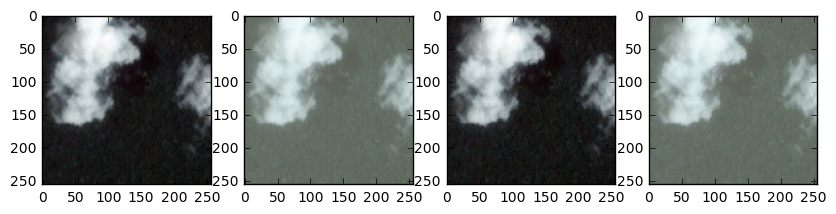

In [10]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.subplots_adjust(wspace=0, hspace=1)
fig = plt.figure()
plt.subplot(1,4, 1)
plt.imshow(stretch_n(jpg_img))
plt.subplot(1,4, 2)
plt.imshow(jpg_img)

#tifs
# plt.subplot(1,4, 3)
tifffile.imshow(stretch_n(jpg_img,0,100),figure=fig,subplot=143)
# plt.subplot(1,4, figure=fig,subplot=143)
tifffile.imshow(jpg_img,figure=fig,subplot=144)




In [5]:
df_train = pd.read_csv("data/train.csv")
df_train.tail(2)

,image_name,tags
40477,train_40477,agriculture clear primary road
40478,train_40478,agriculture cultivation partly_cloudy primary


In [6]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
len(labels)

17

In [7]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [8]:
label_map["artisinal_mine"],inv_label_map[10]

(10, 'artisinal_mine')

In [9]:
from tqdm import tqdm


x_train = []
x_test = []
y_train = []


In [10]:

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('data/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (32, 32)))
    y_train.append(targets)
    

100%|██████████| 40479/40479 [00:55<00:00, 725.23it/s]


In [14]:
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

In [15]:
print(x_train.shape)
print(y_train.shape)


(40479, 32, 32, 3)
(40479, 17)


In [19]:
import numpy as np
from sklearn.metrics import fbeta_score

def optimise_f2_thresholds(y, p, verbose=True, resolution=100):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(17):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.2]*17
    for i in range(17):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            i2 /= resolution
            x[i] = i2
            score = mf(x)
            if score > best_score:
                best_i2 = i2
                best_score = score
        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    return x